<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
#tf.get_logger().setLevel('INFO')

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Create a Helper Function to Plot Graphs:

In [4]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Verify TensorFlow Version and Keras Version

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.5.0


In [6]:
print("Keras version: ", keras.__version__)

Keras version:  2.5.0


### Mount Google Drive to Colab Environment

In [7]:
#from google.colab import drive
#drive.mount('/content/gdrive')

###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [8]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2021-06-20 14:20:20.553179: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
I0620 14:20:22.823386 140033375434624 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
2021-06-20 14:20:22.841730: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-06-20 14:20:22.981106: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-06-20 14:20:23.108822: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
I0620 14:20:23.231711 140033375434624 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GC

###  Exploratory Analysis AG News Subset

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [9]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [10]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


### Review Labels (Categories) 

In [11]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [12]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

The 127,600 news articles are evenly distributed among the 4 categories

In [13]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

We will use the tf.keras.layers.experimental.preprocessing.TextVectorization layer to transform each news article into a "list" of non-negative integers representing the tokens in the news article.

For the purpose of training our models each such "encoding" will have a fixed length corresponding to the news article(s) with the most tokens. Shorter articles will be right-padded with zeros in the encoding. Also to speed up the training process, we will set max_tokens = 1000 so that words not in the vabulary set of top 1000 most common tokes are encoded as 1. But first we set max_tokens = None (which is the default value) in order to get the vocabulary size of the corpus.


In [14]:
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(dataset_all.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7f6ab038e3b0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f6ab038e3b0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f6ab038e3b0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min, sys: 31.7 s, total: 2min 32s
Wall time: 1min 8s


In [15]:
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 95976 vocabulary words in the corpus.


There are 95976 vocabulary words in the corpus.

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [16]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U150')

Let us get the total number of words in the corpus and the sizes of the news articles

In [17]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 14min 9s, sys: 2min 25s, total: 16min 35s
Wall time: 13min 7s


In [18]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.


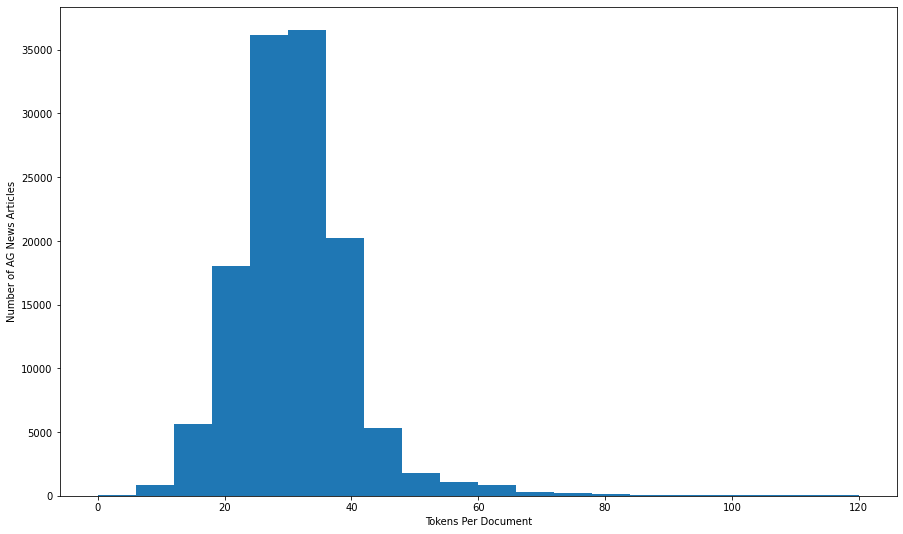

In [19]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

Encode the news articles using the top 1000 most common words in the corpus

In [20]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7f6a54d84440>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f6a54d84440>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f6a54d84440>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 55s, sys: 34 s, total: 2min 29s
Wall time: 1min 7s


The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [21]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In particular, 0 is use for padding, 1 for the unknown words, 2 for the common word, i.e. 'the', etc. Let us look at the same example we encoded previously using the encoder for all the vocabulary words. Note that there are now five 1's denoting words that are not in the top 1000 in frequency.

We encode the same example as before using the new encoder. Note that there are now 5 out of vocabulary words.

In [22]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1000(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2, 999])>

In [23]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


We want to determine the number of non-vocabulary words in each news articles (denoted by 1s in the encoding)

In [24]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 16min 26s, sys: 2min 47s, total: 19min 14s
Wall time: 15min 28s


In [25]:
print(f"Each news article has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")

Each news article has between 3 and 173 tokens in it.


In [26]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True) 

(array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  95,  97, 100]),
 array([  12,    5,   20,   29,   49,   71,  120,  137,  172,  274,  486,
         368,  682,  777,  828, 1346, 1376, 2123, 1610, 2863, 2687, 3018,
        3957, 3315, 4605, 3934, 4148, 5737, 4954, 5072, 6123, 6165, 3255,
        5095, 4596, 3438, 5880, 4205, 3109, 4063, 3555, 3030, 2904, 2294,
        1967, 1716, 2174,  368, 2486,  234, 1246,  747,  573,  547,  520,
         441,  348,  217,  250,  135,  234,   49,  131,  101,   11,  135,
          40,  

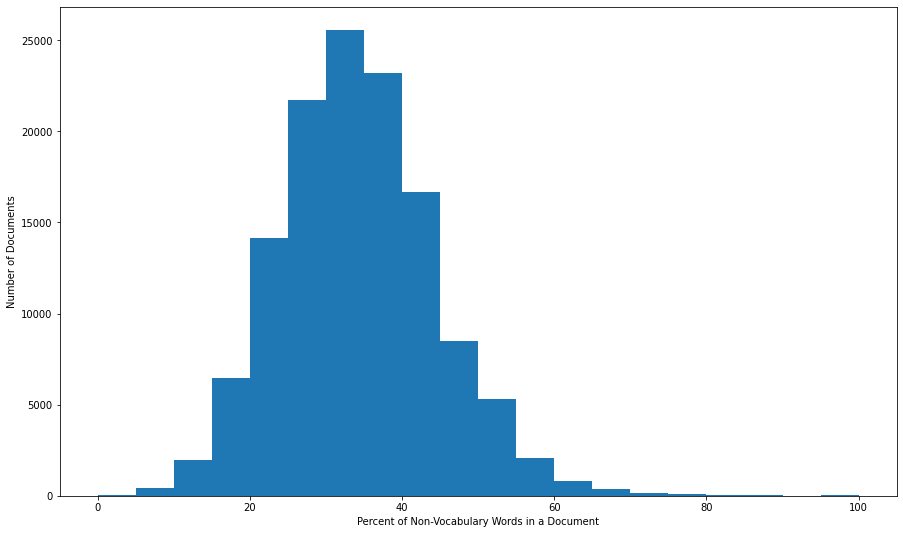

In [27]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [28]:
print(f"There are {count1000} top {len(vocab_1000)} vocabulary words in the corpus.")

There are 2602670 top 1000 vocabulary words in the corpus.


### Preprocessing Data Create Input Pipeline

In [29]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2021-06-20 14:52:33.253384: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
I0620 14:52:35.406958 139959616874368 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0620 14:52:35.407740 139959616874368 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0620 14:52:35.409274 139959616874368 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0620 14:52:35.409451 139959616874368 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is provided by the 

In [30]:
####  Dataset Splits (Training, Test, Validation)
#### .8934 Training, .0470 Test, .0596 Validation

In [31]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [32]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

Review Example with Interger Label(text, label pairs):

Review Example with Interger Label Encoded Classification(text, label pairs):

In [33]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [34]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [35]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [36]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Reuters - Vice President Dick Cheney has\\received a flu shot, aides said on Wednesday, citing his\\history of heart disease as a reason to qualify for a shot\\during a shortage.'
 b' CHICAGO (Reuters) - Northwest Airlines Corp. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=NWAC.O target=/stocks/quickinfo/fullquote"&gt;NWAC.O&lt;/A&gt;, the  No. 4 U.S. air carrier, posted a quarterly loss on Wednesday as  high fuel prices and low fares weighed on the industry.'
 b'TORONTO (CP) - Russia #39;s Severstal has made an offer to buy Stelco Inc., in what #39;s believed to be one of several competing offers emerging for the restructuring but profitable Hamilton steel producer.']

labels:  [0 2 2]
texts:  [b'Nortel Networks Corp., North America #39;s largest telephone-equipment maker, said third-quarter revenue will decline from the second quarter #39;s \\$2.'
 b'A total lunar eclipse expected to create views of a blood-red moon will be visible tonight throughout m

In [37]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b' WASHINGTON (Reuters) - U.S. industrial output growth nearly  stalled last month as production cuts at mines and utilities  nearly swamped a solid performance in factories, a report from  the Federal Reserve showed on Wednesday.'
 b'Images of Saturn sent back to Earth by the Cassini spacecraft reveal a newly discovered ring and at least one new moon, scientists say.'
 b'Visiting Pakistani President Pervez Musharraf agreed with the British Broadcasting Corporation (BBC) here on Monday that the war on terror had made the world less safeand was not addressing the underlying causes of conflict.']

labels:  ['Business', 'Sci/Tech', 'World']

texts:  [b'Canadian bonds gained on concern that the North American economy may slow as higher prices of oil translate into greater transportation and production costs.'
 b'Microsoft has teamed up with consumer electronics firm Thomson to launch set-top boxes supporting Microsoft TV #39;s Internet Protocol Television (IPTV) software platform.

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [38]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [39]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [40]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Here are the 20 least frequent words.

In [41]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [42]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[460,   1,   1,   8,   1,  10,   2, 243, 151, 353, 107,   1,  14,
        285,  94,   5,  70,   1,  62,   1,   1,   7, 661, 495,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [100,  20,   1,  47,  12, 448, 772, 327,   1,   4, 485,   1,   1,
          1, 100, 870,  11, 104,   1, 562,   1,  90,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  2,   1, 137,   1,  78,  98,   2,  39,   1, 137,   1,   1,   1,
          2,  21,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [43]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Canadian bonds gained on concern that the North American economy may slow as higher prices of oil translate into greater transportation and production costs.'
Round-trip:  canadian [UNK] [UNK] on [UNK] that the north american economy may [UNK] as higher prices of oil [UNK] into [UNK] [UNK] and production costs                      

Original:  b'Microsoft has teamed up with consumer electronics firm Thomson to launch set-top boxes supporting Microsoft TV #39;s Internet Protocol Television (IPTV) software platform.'
Round-trip:  microsoft has [UNK] up with consumer electronics firm [UNK] to launch [UNK] [UNK] [UNK] microsoft tv 39s internet [UNK] television [UNK] software [UNK]                       

Original:  b'The HyperTransport Technology Consortium today announced the first HyperTransport technology expansion connector specification. The new EATX Motherboard/Daughtercard '
Round-trip:  the [UNK] technology [UNK] today announced the first [UNK] technology [UNK] [UNK] [

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [44]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [46]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


## Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [47]:
history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 49s 20ms/step - loss: 0.7031 - accuracy: 0.7307 - val_loss: 0.4922 - val_accuracy: 0.8330
Epoch 2/200
1782/1782 [==============================] - 33s 18ms/step - loss: 0.4661 - accuracy: 0.8347 - val_loss: 0.4566 - val_accuracy: 0.8442
Epoch 3/200
1782/1782 [==============================] - 33s 18ms/step - loss: 0.4461 - accuracy: 0.8397 - val_loss: 0.4428 - val_accuracy: 0.8483
Epoch 4/200
1782/1782 [==============================] - 32s 18ms/step - loss: 0.4350 - accuracy: 0.8428 - val_loss: 0.4411 - val_accuracy: 0.8458
Epoch 5/200
1782/1782 [==============================] - 32s 18ms/step - loss: 0.4249 - accuracy: 0.8457 - val_loss: 0.4348 - val_accuracy: 0.8417


In [48]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 9ms/step - loss: 0.4529 - accuracy: 0.8329
Test Loss: 0.4528767764568329
Test Accuracy: 0.8328947424888611


## Plotting Performance Metrics - Single Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [49]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.703,0.731,0.492,0.833
1,0.466,0.835,0.457,0.844
2,0.446,0.840,0.443,0.848
3,0.435,0.843,0.441,0.846
4,0.425,0.846,0.435,0.842


In [51]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

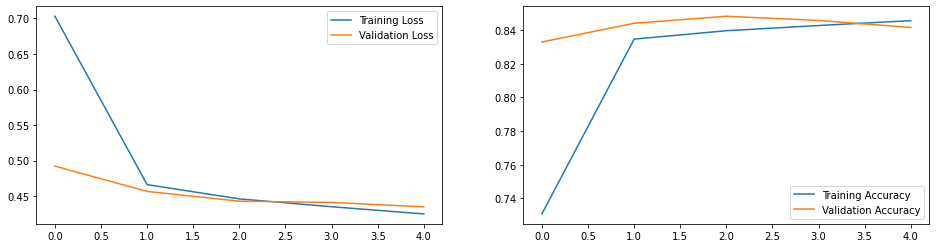

In [52]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary Single Layer Bidirectional RNN

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 138,564
Trainable params: 138,564
Non-trainable params: 0
_________________________________________________________________


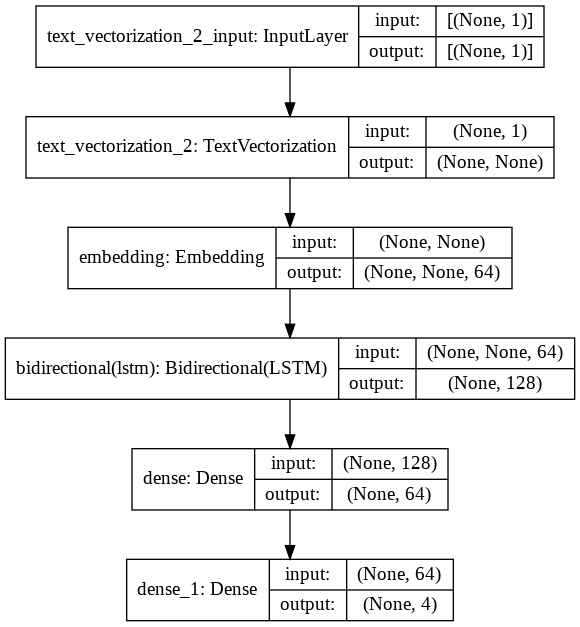

In [54]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [55]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [56]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [57]:
history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 79s 33ms/step - loss: 0.5103 - accuracy: 0.8175 - val_loss: 0.4127 - val_accuracy: 0.8620
Epoch 2/200
1782/1782 [==============================] - 54s 30ms/step - loss: 0.4251 - accuracy: 0.8518 - val_loss: 0.3882 - val_accuracy: 0.8578
Epoch 3/200
1782/1782 [==============================] - 54s 30ms/step - loss: 0.4041 - accuracy: 0.8567 - val_loss: 0.3604 - val_accuracy: 0.8703
Epoch 4/200
1782/1782 [==============================] - 54s 30ms/step - loss: 0.3839 - accuracy: 0.8643 - val_loss: 0.3798 - val_accuracy: 0.8625
Epoch 5/200
1782/1782 [==============================] - 54s 30ms/step - loss: 0.3674 - accuracy: 0.8683 - val_loss: 0.3739 - val_accuracy: 0.8562


In [58]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 13ms/step - loss: 0.3941 - accuracy: 0.8629
Test Loss: 0.3940558433532715
Test Accuracy: 0.8628947138786316


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [59]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [60]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.510,0.817,0.413,0.862
1,0.425,0.852,0.388,0.858
2,0.404,0.857,0.360,0.870
3,0.384,0.864,0.380,0.863
4,0.367,0.868,0.374,0.856


In [61]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

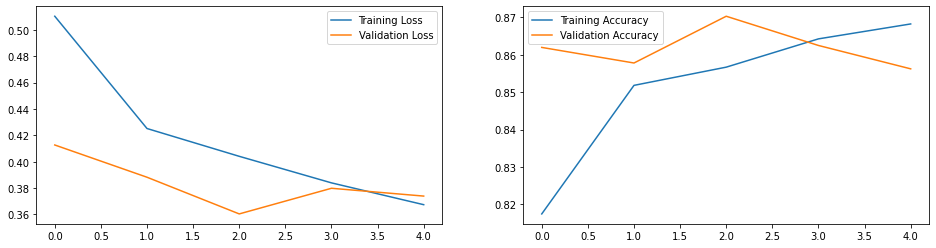

In [62]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [63]:
preds = model.predict(test_dataset)

In [64]:
preds.shape

(7600, 4)

In [65]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [66]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,2.85%,99.93%,0.11%,1.08%,99.84%,0.75%,0.97%,31.65%,92.32%,2.54%,99.98%,0.23%,2.01%,90.32%,99.80%
Sports,96.52%,0.00%,0.02%,98.80%,0.02%,0.17%,98.70%,63.20%,2.12%,0.05%,0.00%,0.63%,0.01%,3.85%,0.00%
Business,0.17%,0.06%,4.62%,0.03%,0.11%,14.84%,0.06%,0.90%,3.82%,88.04%,0.02%,1.39%,96.77%,4.15%,0.18%
Sci/Tech,0.46%,0.00%,95.25%,0.09%,0.03%,84.24%,0.27%,4.25%,1.74%,9.38%,0.00%,97.75%,1.22%,1.67%,0.02%


#### Model Architecture Summary Single Layer Bidirectional RNN

In [67]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

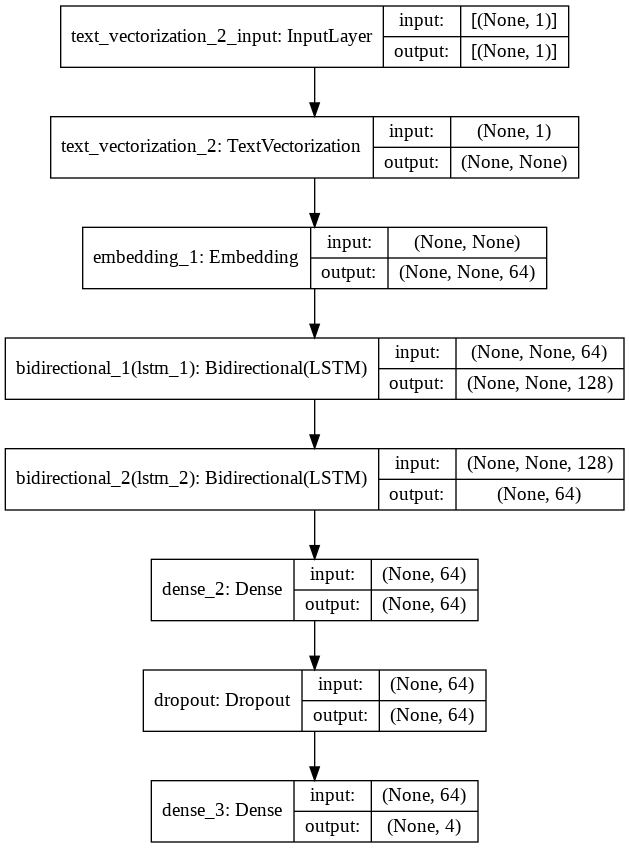

In [68]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
